In [2]:
%pip install scikit-maad

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from maad import sound, features, rois
from maad.util import power2dB, plot2d, format_features, overlay_rois

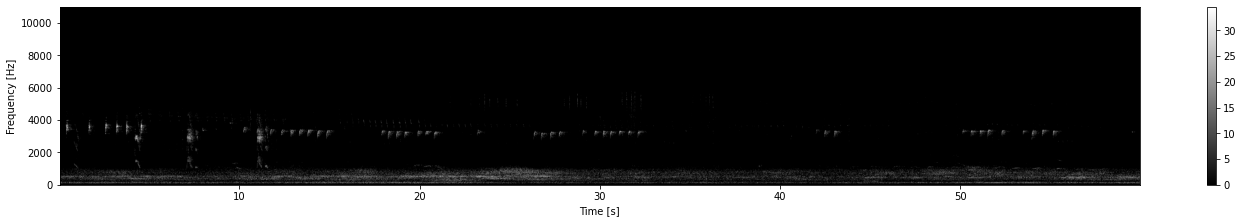

(<AxesSubplot:xlabel='Time [s]', ylabel='Frequency [Hz]'>,
 <Figure size 1423.95x230.45 with 2 Axes>)

In [61]:
%matplotlib inline
s, fs = sound.load('D:/PhD/audio_recorder_downloads_wavs/Tarcutta_April_May_2021/WetA/20210427_AAO/30sec/audio_segment_17.wav')
s_filt = sound.select_bandwidth(s, fs, fcut=100, forder=3, ftype='highpass')

db_max=70  # used to define the range of the spectrogram
Sxx, tn, fn, ext = sound.spectrogram(s_filt, fs, nperseg=1024, noverlap=512)
Sxx_db = power2dB(Sxx, db_range=db_max) + db_max
plot2d(Sxx_db, **{'extent':ext})


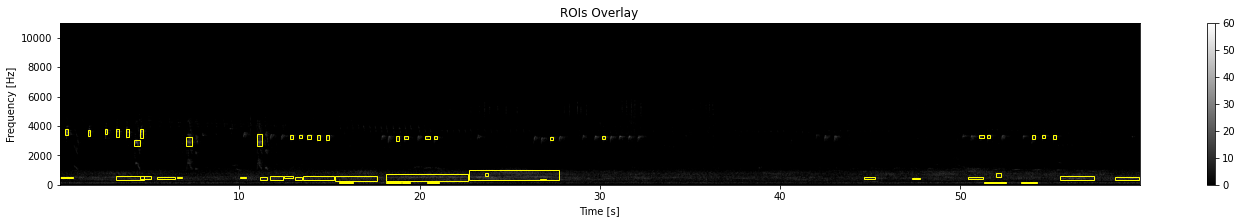

In [62]:
Sxx_db_rmbg, _, _ = sound.remove_background(Sxx_db)
Sxx_db_smooth = sound.smooth(Sxx_db_rmbg, std=1.2)
im_mask = rois.create_mask(im=Sxx_db_smooth, mode_bin ='relative', bin_std=2, bin_per=0.25)
im_rois, df_rois = rois.select_rois(im_mask, min_roi=50, max_roi=None)

# Format ROIs and visualize the bounding box on the audio spectrogram.
df_rois = format_features(df_rois, tn, fn)
ax0, fig0 = overlay_rois(Sxx_db, df_rois, **{'vmin':0, 'vmax':60, 'extent':ext})

In [63]:
df_shape, params = features.shape_features(Sxx_db, resolution='low', rois=df_rois)
df_centroid = features.centroid_features(Sxx_db, df_rois)

# Get median frequency and normalize
median_freq = fn[np.round(df_centroid.centroid_y).astype(int)]
df_centroid['centroid_freq'] = median_freq/fn[-1]

c:\Users\Thomas\conda\envs\audiohandling\lib\site-packages\maad\features\shape.py:343: FutureWarning: `multichannel` is a deprecated argument name for `pyramid_gaussian`. It will be removed in version 1.0. Please use `channel_axis` instead.
  im_pyr = tuple(transform.pyramid_gaussian(Sxx, downscale=2,
c:\Users\Thomas\conda\envs\audiohandling\lib\site-packages\maad\features\shape.py:359: FutureWarning: `multichannel` is a deprecated argument name for `rescale`. It will be removed in version 1.0. Please use `channel_axis` instead.
  im = transform.rescale(im, scale = ratio, mode='reflect',


#TODO - apply k-means and hierarchical clustering to results

c:\Users\Thomas\conda\envs\audiohandling\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
c:\Users\Thomas\conda\envs\audiohandling\lib\site-packages\sklearn\manifold\_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] Computing 37 nearest neighbors...
[t-SNE] Indexed 53 samples in 0.000s...
[t-SNE] Computed neighbors for 53 samples in 0.004s...
[t-SNE] Computed conditional probabilities for sample 53 / 53
[t-SNE] Mean sigma: 0.353782
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.278530
[t-SNE] KL divergence after 950 iterations: 0.636998


Text(0, 0.5, 'tsne dim 2')

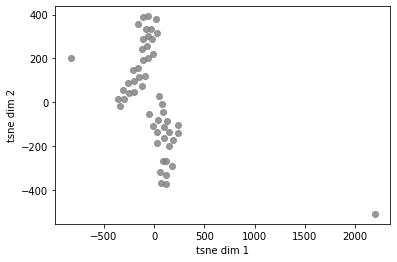

In [64]:
from sklearn.manifold import TSNE

X = df_shape.loc[:,df_shape.columns.str.startswith('shp')]
X = X.join(df_centroid.centroid_freq) # add column and normalize values

tsne = TSNE(n_components=2, perplexity=12, init='pca', verbose=True)
Y = tsne.fit_transform(X)

fig, ax = plt.subplots()
ax.scatter(Y[:,0], Y[:,1], c='gray', alpha=0.8)
ax.set_xlabel('tsne dim 1')
ax.set_ylabel('tsne dim 2')

In [71]:
from sklearn.cluster import DBSCAN
cluster = DBSCAN(eps=.000000000000000000000000000000000001, min_samples=2).fit(Y)
print('Number of soundtypes found:', np.unique(cluster.labels_).size)

Number of soundtypes found: 1


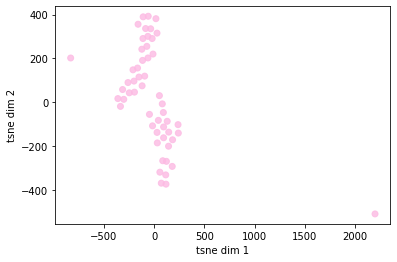

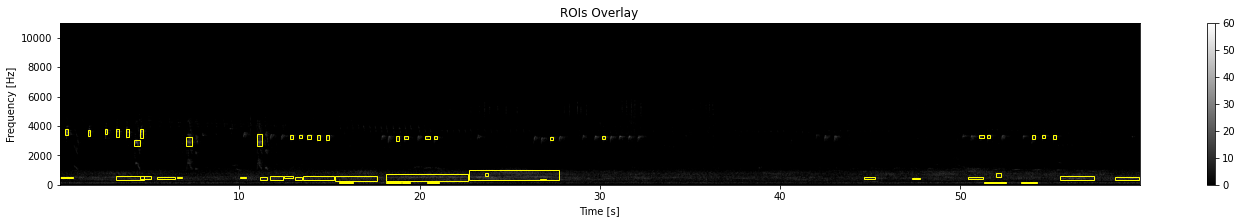

In [72]:
from maad.util import rand_cmap
fig, ax = plt.subplots()
ax.scatter(Y[:,0], Y[:,1], c=cluster.labels_, cmap=rand_cmap(5 , first_color_black=False), alpha=0.8)
ax.set_xlabel('tsne dim 1')
ax.set_ylabel('tsne dim 2')

# Overlay bounding box on the original spectrogram
df_rois['label'] = cluster.labels_.astype(str)
ax0, fig0 = overlay_rois(Sxx_db, df_rois, **{'vmin':0, 'vmax':60, 'extent':ext})